# Graph Generation basato su attributi testuali
Obiettivo di questo notebook è quello di generare per ogni PA e Aggiudicatario una rappresentazione in uno spazio multidimensionale. Questa rappresentazione verrà usata per generare un grafo G(V,E) dove l'insieme dei nodi V rappresenta PA e Aggiudicatari, mentre l'insieme degli archi E definisce relazioni di similarità tra i nodi.

**Note**

Il dataset contiene 0 valori mancanti per il campo *cfStrutturaProponente* ed 8445 valori mancanti per il campo *cfPrimoaggiudicatario*. I valori mancanti verranno eliminati durante la fase di generazione dei documenti sintetici. Nonostante l'eliminazione di elementi con valori nulli, essendo il dataset molto sporco ci sono diversi  valori inconsistenti. Ad esempio ci sono stringhe formate da soli spazi o di sola punteggiatura speciale, stringhe non associate a reali p.iva o codici fiscali (e.g. "extra UE USA", "USA", "USA00004215"). Per fare ricerche basate su sottostringhe esegui il comando: 

``` python
example_df = df[pd.notnull(df['cfPrimoaggiudicatario'])]
example_df[example_df['cfPrimoaggiudicatario'].str.contains("USA|usa")==True]
```

Si definisce di seguito la soluzione proposta.


## Soluzione 1: creazione di vettori basati sul tf-idf

Ogni bando di gara è caratterizzato da un campo *oggetto*. Quindi per ogni elemento *i* ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad *i*.

A partire da D = {d<sub>i</sub> | i ∈ { PA ⋃  Fornitori}} è possibile creare la matrice W ∈ R<sup>(n,m)</sup>, ottenuta calcolando il TF-IDF su D.

In questo modo è possibile creare un grafo G_text(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(w<sub>u</sub>, w<sub>v</sub>)}  solo e soltanto se cos(w<sub>u</sub>, w<sub>v</sub>) >= *threshold*.

cos(w<sub>u</sub>, w<sub>v</sub>) ∈ [0,1], dove 0 implica che i documenti d<sub>u</sub>, d<sub>v</sub> sono completamente diversi, mentre 1 implica che i documenti hanno la stessa distribuzione di termini.


**Note**

- Dati i ∈ {PA} e j ∈ {Fornitori}, è possibile che se tutte le gare vinte da j riguardassero sempre i come struttura proponente (PA) e se tutte le gare di i siano vinte da j allora d<sub>i</sub> == d<sub>j</sub>, quindi cos(w<sub>i</sub>, w<sub>j</sub>) = 1.

- E’ possibile aggiungere al grafo G<sub>text</sub> nuovi nodi come l’insieme delle provincie e regioni. In questo caso è possibile associare ad ogni provincia (regione) i un documento sintentico d_i ottenuto concatenando tutti gli oggetti delle PA che insistono su i.  

- La matrice W non gestisce casi si sinonimia e polisemia (problema risolto con la soluziione successiva);

## Soluzione 2: creazione di vettori basati su word embedding dei top term pesati per il loro tf-idf

   Come nel precedente caso per ogni elemento i ∈ { PA ⋃  Fornitori }, dove PA (Fornitori) è l’insieme delle Pubbliche amministrazioni (Fornitori) presenti nel dataset Anac,  è possibile creare un documento sintetico d<sub>i</sub> ottenuto concatenando il testo di tutti gli oggetti delle gare appartenenti ad i. 

Sia *L* l’insieme delle top n ∈ N parole più frequenti (in termine di tf-idf)  e *D* = {d’<sub>i</sub> | i ∈ { PA ⋃  Fornitori } }, dove d’<sub>i</sub> = {(l, w) | l ∈ L e w = TF-IDF(l, d<sub>i</sub>)}. 

In questo modo per ogni i è possibile costruire un vettore v<sub>i</sub>  dato dalla somma pesata degli embedding dei termini l contenuti in d’<sub>i</sub>. 
Per esempio, sia  L = [“fattura”, “acquisto”, “fornitura”] l’insieme dei top 3 termini in D, e sia D ={d<sub>1</sub>, d<sub>2</sub>, d<sub>3</sub>}, dove:

- d<sub>1</sub> = [(“acquisto”: w(1,acquisto)), (“fattura”: w(1,fattura))]  
- d<sub>2</sub> = [(“fattura”: w(2,fattura)), (“fornitura”: w(2,fornitura))]  
- d<sub>3</sub> = [(“acquisto”: w(3,acquisto)), (“fattura”: w(3,fattura)), (“fornitura”: w(3,fornitura))]

Quindi è possibile per ogni d<sub>i</sub> calcolare una rappresentazione vettoriale cosi definita:

 
embedding(d<sub>i</sub>) = $ \frac{1}{\sum_{wj∈di} wj} * \sum_{(tj,wj)∈di}$ w<sub>j</sub> * embedding(t<sub>j</sub>)
    
    
 

dove embedding(t<sub>j</sub>) è l’embedding del termine t<sub>j</sub> appreso su Wikipedia (vedi [qui](https://fasttext.cc/docs/en/support.html) per maggiori dettagli).

In questo modo è possibile creare un grafo G<sub>text</sub>(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(v<sub>du</sub>, v<sub>dv</sub>)}  solo e soltanto se cos(v<sub>du</sub>, v<sub>dv</sub>) >= threshold.



## Soluzione 3: creazione di vettori basati su word embedding dei top term 

   Questa soluzione è molto simile alla precedente. Tuttavia in questa soluzione tutti i termini contribuiscono in ugual misura all'embedding del documento. 
   
   In questo modo è possibile rappresentare d<sub>i</sub> come il centroide dei suoi termini:

 embedding(d<sub>i</sub>) = $ \frac{1}{\{tj | tj∈di\}} * \sum_{tj ∈ di}$ embedding(t<sub>j</sub>)
 
 
## Future Works

1. Al fine di discriminare maggiormente i documenti, si possono analizzare non sono parole di lunghezza 1, ma anche n-grammi (in questo modo documenti come {"fattura luce", "fattura telefono"} risultano meno simili )

In [88]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

import pandas as pd
import numpy  as np
import csv
import datetime
from time import time
import timeit

#%matplotlib inline

import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [97]:
t0 = time()
file = "data/anac/anac_indicepa_2017.tsv"
df = pd.read_csv(file, sep="\t")

total = time() - t0
    
print("Loading dataframe done in %0.3f sec" %  total)
df.info(memory_usage='deep')

Loading dataframe done in 11.986 sec
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321761 entries, 0 to 1321760
Data columns (total 24 columns):
cfStrutturaProponente                1321761 non-null int64
cig                                  1321754 non-null object
denominazioneStrutturaProponente     1321602 non-null object
oggetto                              1321651 non-null object
sceltaContraente                     1321758 non-null object
importoAggiudicazione                1321760 non-null float64
importoSommeLiquidate                1321760 non-null float64
dataInizio                           1321761 non-null object
dataUltimazione                      1148870 non-null object
jsonPartecipanti                     1321761 non-null object
jsonAggiudicatari                    1321761 non-null object
totalePartecipanti                   1321761 non-null int64
totaleAggiudicatari                  1321761 non-null int64
totaleRaggruppamentopartecipanti     1321761 non-null int6

## Creazione dei documenti sintetici d<sub>i</sub>

In questa sezione, per ogni attributo in *columns_to_aggregate*, è calcolato il suo documento sintetico 

In [3]:
columns_to_aggregate = {("cfStrutturaProponente","PA"), ("cfPrimoaggiudicatario","AGG")}

In [4]:
def aggregateByOggetto(col_groupBy, col_toAgg, df):
    """
    col_groupBy: è la colonna per la quale effettuare l'aggragazione
    col_toAgg: è la colonna contenente le informazioni non strutturate, i.e. campo "oggetto"
    df: input dataframe
    """
    df_noEmpty = df.dropna(subset=[col_toAgg], axis=0)
    new_series = df_noEmpty.groupby(col_groupBy)[col_toAgg].apply(lambda x: ' '.join(x)) 
    return pd.DataFrame(new_series)

In [5]:
final_df = pd.DataFrame(columns=['codiceFiscaleStruttura', 'oggetto', "tipoStruttura"])

In [6]:
for col, type_col in columns_to_aggregate:
    t0 = time()
    
    df_no_null = df[pd.notnull(df[col])]
    aggregate_df = aggregateByOggetto(col, "oggetto", df_no_null) 
    total = time() - t0

    aggregate_df['tipoStruttura'] = [type_col] * aggregate_df.shape[0]
    aggregate_df.reset_index(inplace = True)
    aggregate_df.rename(columns={col: 'codiceFiscaleStruttura'}, inplace = True)

    final_df = final_df.append(aggregate_df)
    
    print("Aggregation of attribute %s done in %0.3f sec" % (col, total))
    print(aggregate_df["oggetto"].head(3))


Aggregation of attribute cfStrutturaProponente done in 1.061 sec
0    MANUTENZIONE RECINZIONE E MESSA IN SICUREZZA C...
1    MANUTENZIONE AUTOMEZZO RIFIUTI RIPARAZIONE MEZ...
2    CORSO ANTINCENDIO NOMINA MEDICO E VISITE MEDIC...
Name: oggetto, dtype: object
Aggregation of attribute cfPrimoaggiudicatario done in 10.166 sec
0    SOSTITUZIONE CALDAIA CENTRALE TERMICA AMPLIAME...
1    servizio 22202 organizzazione incontri daffari...
2    SENSORI NGIMU with Housing and Battery  NGIMU ...
Name: oggetto, dtype: object


In [7]:
pd.options.display.max_colwidth = 500
final_df.head()

,codiceFiscaleStruttura,oggetto,tipoStruttura
0,8010803,MANUTENZIONE RECINZIONE E MESSA IN SICUREZZA CAMPO SPORTIVO TRAMITE MEPA MATERIALE VARIO PER MANUTENZIONE VERDE PUBBLICO FORNITURA ACQUA POTABILE 3 E 4 TRIMESTRE 2017 FORNITURA OLIO PER MISCELA ACQUISTO TRAMITE MEPA MATERIALE PER MANUTENZIONE PUBBLICA ILLUMINAZIONE ACQUISTO MATERIALE VARIO PER PALCHI COMUNALI ACQUISTO CLORO PER ACQUEDOTTO COMUNALE SERVIZIO FORNITURA ACQUA POTABILE 2 TRIMESTRE 2017 ACQUISTO TRAMITE MEPA LAMPADE PER CIMITERO COMUNALE ACQUISTO TRAMITE MEPA MATERIALE VARIO PER ...,PA
1,31730948,MANUTENZIONE AUTOMEZZO RIFIUTI RIPARAZIONE MEZZO DEI RIFIUTI RICERCA PERDITE IDRICHE E RIPARAZIONE LAVORI DI SPURGO RETE FOGNANTE IMPEGNO E AFFIDAMENTO FORNITURA MATERIALI PER MANUTENZIONE STRADE E PIAZZE RIPARAZIONE FAX FORNITURA COPIE PROGETTO RETE FOGNANTE FORNITURA SERVIZIO ABBONAMENTO ON LINE PRATICHE UFFICIO TECNICO MANUTENZIONE DEPURATORE PER TRE ANNI CALENDARI PER RACCOLTA DIFFERENZIATA FORNITURA CARBURANTE PER AUTOMEZZI COMUNALI FORNITURA POMPA SOMMERSA PIU ANNESSI PER POZZO CARLUCC...,PA
2,32020943,CORSO ANTINCENDIO NOMINA MEDICO E VISITE MEDICHE PUBBLICAZIONE AVVISO CONVOCAZIONE ASSEMBLEA SOCI MANIFESTI MORTUARI MANUTENZIONE ORDINARIA IMPIANTI TERMICI CANONE ANNUALE PROTOCOLLO PA,PA
3,38870945,STAGIONE INVERNALE 20162017 SERVIZIO DI SGOMBERO NEVE IMPEGNO DI SPESA SERVIZIO DI RACCOLTA DIFFERENZIATA PORTA A PORTA TRASPORTO E SMALTIMENTO DELLA FRAZIONE INDIFFERENZIATA AGGIUDICAZIONE ACQUISTO MATERIALE PER LA PUBBLICA ILLUMINAZIONE IMPEGNO DI SPESA SERVIZIO DI RACCOLTA TRASPORTO E SMALTIMENTO DEI RIFIUTI SOLIDI URBANI E RACCOLTA DIFFERENZIATA AFFIDAMENTO PER LA DURATA DI MESI TRE CONTROLLO DELLE ACQUE DESTINATE AL CONSUMO UMANO AFFIDAMENTO DEL SERVIZIO UTENZE GAS EDIFICI COMUN...,PA
4,40470072,FORNITURA ENERGIA ELETTRICA 20172018 FORNITURA OMAGGI SOCIALI AUTENTICHE NOTARILI POLIZZA FIDEJUSSORIA SPORTELLO TELEMATICO POLIZZA ASSICURATIVA GARANZIA PORTAVALORI FURTO RAPINA FORNITURA OMAGGI SOCIALI POLIZZA ASSICURATIVA CAUZIONE VARIE VIACARD CONSULENZE AMMINISTRATIVE E FISCALI POLIZZA ASSICURATIVA COMMERCIANTE PROTEZIONE PATRIMONIO E PERSONE CANONE ANNUO ASSISTENZA SOFTWARE POLIZZA FIDEIUSSORIA TASSE AUTOMOBILISTICHE,PA


In [90]:
t0 = time()
file_name = "data/oggetti_aggregati.pickle"
final_df.to_pickle(file_name)
total = time() - t0

print("Dataset stored in %0.3f sec" % total)

NameError: name 'final_df' is not defined

In [ ]:
## libera memoria
#una volta lanciato questo comando verranno perse tutte le variabili inizializzate in precedenza
#del [[df, final_df, aggregate_df]]
%reset

## Creazione Matrice TF-IDF

La matrice dei tf-idf verrà utilizzata per entrambe le soluzioni. Prima di generare la matrice, sono eseguite le seguenti attività di preprocessing:
- Tokenization;
- Eliminazione di stopword (e.g. di, a, dell, quell, etc. );
- Selezione di parole composte solo da lettere e di cardinalità maggiore di 2 (e.g. eliminazione di codici di fattura)

Alla matrice dei tf-idf generata è applicala la norma L2.


Inoltre si visualizzano di seguito le top 40 parole in termini di tf-idf.



In [91]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

import pandas as pd
import numpy  as np
import csv
import datetime
from time import time

#%matplotlib inline

import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [92]:
from nltk.stem.snowball import ItalianStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from pylab import *

class StemmedCountVectorizer(TfidfVectorizer):
    
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])
        
def get_TFIDFmatrix_vect(data, do_stemming):
    """
    data: input textual collection
    do_stemming: boolean. If True execute stemming, otherwise analyze only tokenized words (words are composed at least 2 chars and do not contains numbers)
    
    returns a tuple <tf, matrix> where tf is the vectorizer and matrix is the normalized matrix of tfidf
    """
    t0 = time()
    
    min_df = 10
    
    if do_stemming:
        
        italian_stemmer = ItalianStemmer()
        tf = StemmedCountVectorizer(token_pattern=u'([a-z]{2,})', min_df = min_df, analyzer="word", stop_words=stopwords.words('italian'),  norm='l2')

    else:
        tf = TfidfVectorizer(token_pattern=u'([a-z]{2,})', stop_words=stopwords.words('italian'), min_df = min_df, norm='l2') #CountVectorizer supports counts of N-grams of words or consecutive characters.
    
    matrix = tf.fit_transform(data)  
    return matrix, tf

def plotTopNWords(sorted_frequents_words, N, title):
    """frequents_words: list of frequents words. Type: tuple(str, numpy.int64)
       N: number of words to plot 
    """
    #most_frequents_words = sorted(sorted_frequents_words, key = lambda x: x[1], reverse=True)
    x, y = zip(*sorted_frequents_words[0:N]) # unpack a list of pairs into two tuples

    fig = plt.figure()
    ax1 = fig.add_subplot(111)  # Create matplotlib axes
    ax1.set_title(title)
    ax1.plot(x, y)

    for tl in ax1.get_xticklabels():
        tl.set_rotation(90)

    file_name = 'imgs/top'+str(N)+'_words_plot.png'  
    fig.tight_layout() 
    plt.savefig(file_name, pad = 0) #png

    plt.clf
    return file_name

def boxplotdata(data_to_plot, title, x_names, filename):
    """
    data_to_plot: array containing variables to plot (e.g. [a,b,c] where a,b,c are arrays)
    title of the boxplot
    x_names: list containing axis names (e.g. ["boxplot1", "boxplot2"])
    filename: filename where saving the boxplot
    """
    #data_to_plot = [intersection]
    #k = len(D_embeddings[0])

    dim = range(1,len(x_names) +1)
    
    
    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the boxplot
    bp = ax.boxplot(data_to_plot)
    plt.xticks(dim, x_names)
    plt.title(title)


    for line in bp['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # top of median line
        # overlay median value
        text(x + 0.05, y, '%.2f' % y, horizontalalignment='center') # draw above, centered

    for line in bp['boxes']:
        x, y = line.get_xydata()[0] # bottom of left line
        text(x - 0.05,y, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below
        x, y = line.get_xydata()[3] # bottom of right line
        text(x - 0.05,y, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below

    plt.savefig(filename)
    plt.clf()
    plt.close()

In [93]:
from time import time
df_file_name = "data/oggetti_aggregati.pickle"

t0 = time()
df = pd.read_pickle(df_file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

Dataset loaded in 0.294 sec


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254124 entries, 0 to 245283
Data columns (total 3 columns):
codiceFiscaleStruttura    254124 non-null object
oggetto                   254124 non-null object
tipoStruttura             254124 non-null object
dtypes: object(3)
memory usage: 7.8+ MB


In [95]:
t0 = time()

matrix, tf = get_TFIDFmatrix_vect(df.oggetto, False)
total = time() - t0
print("TFIDF matrix done in %0.3f sec" % total)
print("Shape TFIDF matrix", matrix.shape)



TFIDF matrix done in 12.883 sec
Shape TFIDF matrix (254124, 44323)


### Plot termini più discriminativi e distribuzione di termini per documento

Si può osservare come è poissibile identificare una decina di termini molto discriminativi (.e. fattura, fornitura, acquisto, pagamento, etc.). Inoltre, si nota che i documenti sintetici generati hanno, nella maggioranza dei casi, un numero di parole distinte compreso tra 6 e 21.

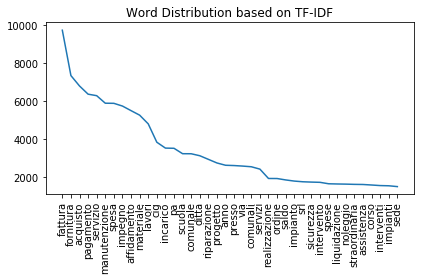

In [15]:
top_terms = 40

#Tf-Idf distribution
scores = zip(tf.get_feature_names(), np.asarray(matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
file_name = plotTopNWords(sorted_scores, top_terms,  "Word Distribution based on TF-IDF")

In [16]:
rows = (matrix != 0).sum(1)
values = np.squeeze(np.asarray(rows))

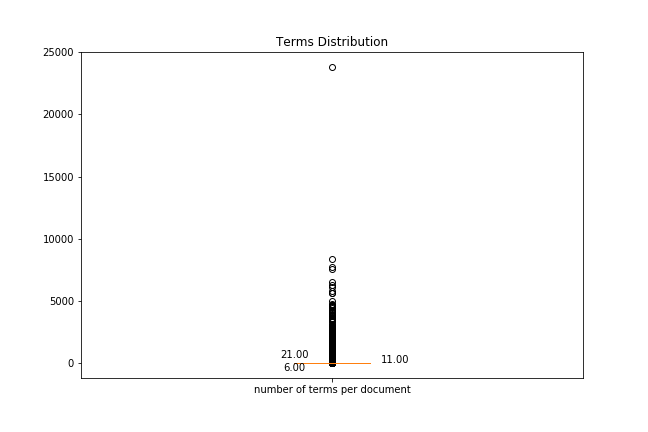

In [17]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(values)
plt.xticks([1], ["number of terms per document"])
plt.title("Terms Distribution")


for line in bp['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x + 0.05, y, '%.2f' % y, horizontalalignment='center') # draw above, centered

for line in bp['boxes']:
    x, y = line.get_xydata()[0] # bottom of left line
    text(x,y , '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below
    x, y = line.get_xydata()[3] # bottom of right line
    text(x, y*50, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below

f_img = "imgs/n6/term_distribution.png"    
plt.savefig(f_img)
plt.clf()
plt.close()


i = Image(f_img)
display(i)

In [18]:
#genera lo stesso plot in plotly
#rows = (matrix != 0).sum(1)
#values = pd.value_counts(np.squeeze(np.asarray(rows)))

#trace = go.Box(y=np.squeeze(np.asarray(rows)))
#py.iplot([trace])    

In [19]:
#seleziona i 269 oggetti aventi una rappresentazione tfidf composta da soli zero
states = matrix.getnnz(1)== 0
row_indices = np.where(states)[0]
df.iloc[row_indices].head()

,codiceFiscaleStruttura,oggetto,tipoStruttura
185,000003567,97 INFLUENCER,AGG
201,000007199,665 ANJEZE PELINI,AGG
1362,00077910289,CONFAGRICOLTURA,AGG
2071,00103590220,CDATAOlive CDATAOlive CDATAOlive,AGG
4408,00167710359,Z601E221B6,AGG


## Implementazione Soluzione 1

In questa sezione verranno caricati i documenti sintetici salvati in *data/oggetti_aggregati.pickle* e a partire da questi è generata la matrice tf-idf.
Alla matrice sono poi applicate tecniche di dimensionality reduction (i.e. SVD) e standardization. 

### Dimensionality reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import DBSCAN
t0 = time()
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
preprocessing = make_pipeline(svd, normalizer).fit_transform(matrix)
total = time() - t0
print("Preprocessing done in done in %0.3f sec" % total)

np.save("data/n6/matrix_tfidf", preprocessing)

In [ ]:
%reset

# Implementazione Soluzione 2

In questa sezione verranno caricati i documenti sintetici salvati in *data/oggetti_aggregati.pickle* e per ogni elemento verrà generata una rappresentazione vettoriale basata su *FastText*. Come per l'implementazione della soluzione 1 verranno analizzati solo i top k termini piu frequenti (rispetto al tf-idf)

**NOTA BENE**

Per k = 1000, la generazione della matrice degli embedding (i.e. embedding_matrix) richiede qualche minuto; mentre per k = 44323 (ossia matrice termini documenti generata impostando min_df=10. Per maggiori dettagli, vedi  l'implementazione del metodo *get_TFIDFmatrix_vect* ) la generazione della matrice degli embedding richiede 3 giorni.

In [30]:
from time import time
import pandas as pd
import numpy  as np
import math

import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [46]:
def calculate_embedding(tf, tfidf_matrix, n_rows, weigth_embedding = False) :
    """
    tf: Tf-idf vectorizer
    tfidf_matrix: matrix of tfidf
    n_row: number of rows to analize
    weigth_terms: Boolean. If true weigth the term embedding with its tfidf
    """
    
    embedded_matrix = np.zeros((n_rows,300), "float32")
    index_term_vocabulary = tf.get_feature_names()

    for i in range(0, n_rows):

        counter_d = 0

        #for term in the document:
        for index_t in tfidf_matrix[i].indices: 
            
            tfidf = tfidf_matrix[i,index_t]
            term = index_term_vocabulary[index_t]
            
            if term in jp_model.vocab:
                    
                    if(weigth_embedding):
                        counter_d += tfidf
                        embedded_matrix[i] += (jp_model.get_vector(term) * tfidf)
                    else:
                        counter_d += 1
                        embedded_matrix[i] += jp_model.get_vector(term)
                        
                    
        if counter_d > 0:

            embedded_matrix[i] /= counter_d
    
    return embedded_matrix

In [32]:
file_name = "data/oggetti_aggregati.pickle"

t0 = time()
df = pd.read_pickle(file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

Dataset loaded in 0.142 sec


In [33]:
from gensim.models import KeyedVectors
t0 = time()
jp_model = KeyedVectors.load_word2vec_format('data/fasttext/cc.it.300.vec.gz')

total = time() - t0
print("Fastext model loaded in %0.3f sec" % total)

Fastext model loaded in 462.946 sec


#### Calcola intersezione tra i termini della matrice tf-idf e il vocabolario del modello fasttext

In [24]:
not_present = []

t0 = time()
for term in tf.vocabulary_:
    if term not in jp_model.vocab:
            not_present.append(term)
total = time() - t0
print("Intersection done in %0.3f sec" % total)        

len_not_present = len(not_present) 
percentage = len_not_present / len(tf.vocabulary_) 
print("Percentage of absent terms: %0.2f (i.e. %d terms)" % (percentage, len_not_present)) 
print("Printing some term not present in Fastext model: ",not_present[:10])

Intersection done in 0.017 sec
Percentage of absent terms: 0.19 (i.e. 8466 terms)
Printing some term not present in Fastext model:  ['vvuu', 'tecnoware', 'cinquefrondi', 'xtm', 'kiocera', 'ddll', 'aficio', 'audioluci', 'anutel', 'illuminazioneimpegno']


In [40]:
t0 = time()
weighted = False
embedded_matrix = calculate_embedding(tf, matrix, matrix.shape[0], weighted)

total = time() - t0 
print("Embedding done in %0.3f sec" % total)

Embedding done in 255.344 sec


In [41]:
t = len(tf.vocabulary_)
f = "data/n6/matrix_embedding_" + str(t) + "terms_weigthed" + str(weighted) 
np.save(f, embedded_matrix)

In [42]:
from sklearn.preprocessing import Normalizer
normalized_matrix = Normalizer(copy=False).fit_transform(embedded_matrix)
f = "data/n6/normalized_matrix_embedding_" + str(t) + "terms_weigthed" + str(weighted) 
np.save(f, normalized_matrix)

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/sklearn/utils/extmath.py:71: RuntimeWarning:

invalid value encountered in sqrt



In [53]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Costruzione del Grafo

A partire dalla matrice dei documenti sintetici calcolata nelle precedenti sezioni (tf-idf matrix o embedding matrix, entrambe normalizzate con L2) è possibile generate il  grafo G<sub>text</sub>(V, E) dove V = { PA ⋃ Fornitori } ed esiste un arco pesato e = {(u, v) ∈ E | p(e) = cos(v<sub>du</sub>, v<sub>dv</sub>)}  solo e soltanto se cos(v<sub>du</sub>, v<sub>dv</sub>) >= *t*.

Impostiamo la threshold *t* = 0.6 

### Generazione Matrice similarità

In [54]:
import pandas as pd
import numpy  as np
import csv
import datetime
from time import time
import timeit

#%matplotlib inline

import plotly.offline as py
import plotly.plotly as py_on
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [69]:
#file_name = "data/n6/normalized_matrix_embedding_44323terms_weigthedFalse.npy"
file_name = "data/n6/normalized_matrix_embedding_44323terms_weigthedTrue.npy"
#file_name = "data/n6/matrix_tfidf.npy"

matrix = np.load(file_name).astype('float32')

In [70]:
#check how many rows are all zero (it generates divisions by zero)
zero_rows = len(np.where(~matrix.any(axis=1))[0])
print("there are %d all zero rows" % zero_rows)

there are 558 all zero rows


In [71]:
#seleziona gli oggetti aventi una rappresentazione basata su embedding composta da soli zero
df_file_name = "data/oggetti_aggregati.pickle"
t0 = time()
df = pd.read_pickle(df_file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)
df.iloc[np.where(~matrix.any(axis=1))[0]].head()

Dataset loaded in 0.165 sec


,codiceFiscaleStruttura,oggetto,tipoStruttura
185,000003567,97 INFLUENCER,AGG
201,000007199,665 ANJEZE PELINI,AGG
1362,00077910289,CONFAGRICOLTURA,AGG
2071,00103590220,CDATAOlive CDATAOlive CDATAOlive,AGG
2922,00125480210,RUECKERSTATTUNG JAHRESGEBUEHR 2017,AGG


In [72]:
# NOTE: for cosine similarity you should normalize (in L2 norm) your input matrix
import faiss                   # make faiss available
index = faiss.IndexFlatIP(matrix.shape[1])   # build the index using inner product (ip)
print(index.is_trained)
index.add(matrix)                  # add vectors to the index
print(index.ntotal)

True
254124


In [73]:
from time import time

t0 = time()
k = 1000  # we want to see k nearest neighbors
#Matrix I is the results matrix
#Matrix D is the matrix of squared distances. It has the same shape as I and indicates for each result vector at the query’s squared Euclidean distance.
#
D, I = index.search(matrix, k) # sanity check

total = time() - t0
print("Cosine Similarity Matrix done in %0.3f sec" % total)
#print(I)
#print(D)


Cosine Similarity Matrix done in 243.613 sec


In [74]:
np.save(file_name + "similarity_D_" + str(k) + "_k", D)
np.save(file_name + "similarity_I_" + str(k) + "_k", I)

In [75]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Confronto Matrici 

La matrice generata dai tf-idf (i.e. Soluzione 1) sfrutta correlazioni dirette tra termini. Ossia due documenti sono simili se condividono gli stessi termini. Le matrici generate a partire dagli embedding dei termini (i.e. Soluzione 2, Soluzione 3) invece codificano correlazioni indirette tra termini. In quest'ultimo caso, due documenti sono simili se condividono termini semanticamente simili (e.g. raccolta, rifiuti, smaltimento).  

Per verificare se le rappresentazioni estratte per ogni documento codificano le stesse informazioni, si analizza l'intersezione dei k documenti più simili sfruttando le 3 matrici generate:
- Matrice tf-idf
- Matrice embedding
- Matrice embedding pesata con tf-idf

Per ogni coppia di matrici m1,m2, se queste codificano le stesse informazioni, allora per ogni documento d_i:

  
intersection(get_most_similar(m1, i, k), get_most_similar(m2, i, k))  ~= k,

dove *get_most_similar(mj, i, k)* restituisce i k documenti più simili al documento di indice i utilizzando la matrice mj. 



In [1]:
import pandas as pd
import numpy  as np
import csv
import datetime
from time import time
import timeit

#%matplotlib inline

from IPython.display import Image
from IPython.display import display

import matplotlib.pyplot as plt

In [63]:
from pylab import *

def bar_plot(values, title, filename):

    # Turn interactive plotting off
    plt.ioff()

    p1 = plt.bar(values.index, values.values)

    plt.xlabel('# common documents')
    plt.title(title)

    #plt.show()
    plt.savefig(filename)
    plt.close()
    plt.clf
    i = Image(filename)
    display(i)

def get_intesection(set1, set2):
    intersection = []
    rows = len(set1)
    k = len(set1[0])
    for row in range(0, rows):
        i =  set(set1[row]).intersection(set(set2[row])) 
        #res = len(i) / k
        #intersection.append(float("{0:.2f}".format(res)))
        res = len(i)
        intersection.append(res)

    #return pd.value_counts(intersection) 
    return intersection

def box_plot(values, axis_names, title, filename):

    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the boxplot
    bp = ax.boxplot(values)
    dim = range(1, len(axis_names)+1)
    
    plt.xticks(dim, axis_names, rotation=90)
    plt.title(title)


    for line in bp['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # top of median line
        # overlay median value
        text(x + 0.05, y, '%.2f' % y, horizontalalignment='center') # draw above, centered

    for line in bp['boxes']:
        x, y = line.get_xydata()[0] # bottom of left line
        text(x - 0.05,y, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below
        x, y = line.get_xydata()[3] # bottom of right line
        text(x - 0.05,y, '%.2f' % y, horizontalalignment='center', verticalalignment='top')      # below

    # Save the figure
    
    fig.savefig(filename, bbox_inches='tight')

    plt.close()
    plt.clf
    i = Image(filename)
    display(i)

In [16]:
I_embeddings_weighted = np.load("data/n6/normalized_matrix_embedding_44323terms_weigthedTrue.npysimilarity_I_100_k.npy")
D_embeddings_weighted = np.load("data/n6/normalized_matrix_embedding_44323terms_weigthedTrue.npysimilarity_D_100_k.npy")

I_embeddings = np.load("data/n6/normalized_matrix_embedding_44323terms_weigthedFalse.npysimilarity_I_100_k.npy")
D_embeddings = np.load("data/n6/normalized_matrix_embedding_44323terms_weigthedFalse.npysimilarity_D_100_k.npy")

I_tfidf= np.load("data/n6/matrix_tfidf.npysimilarity_I_100_k.npy")
D_tfidf = np.load("data/n6/matrix_tfidf.npysimilarity_D_100_k.npy")

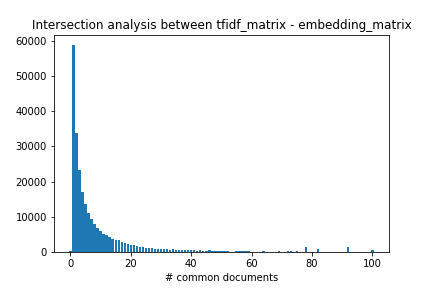

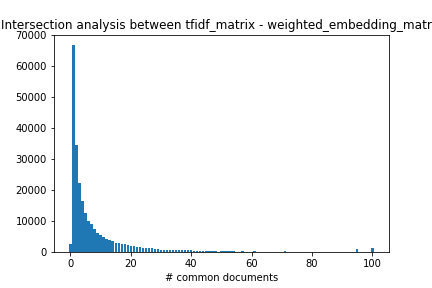

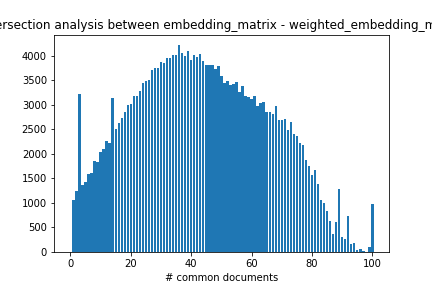

In [53]:
I_array = [I_tfidf, I_embeddings, I_embeddings_weighted]
k = len(I_embeddings[0])
labels = ["tfidf_matrix", "embedding_matrix", "weighted_embedding_matrix"]
intersection_array = []
str_labels = []

for i in range(len(I_array)):
    for j in range(i+1, len(I_array)):

        intersection = get_intesection(I_array[i], I_array[j])
        intersection_array.append(intersection[:100000])
        title = "Intersection analysis between " + labels[i] + " - " + labels[j]
        f_img = "imgs/n6/intersection_"+ labels[i] + "." + labels[j] + "_k"+ str(k)+ ".png"
        str_labels.append(labels[i] + " vs " + labels[j])
        bar_plot(pd.value_counts(intersection), title,f_img)


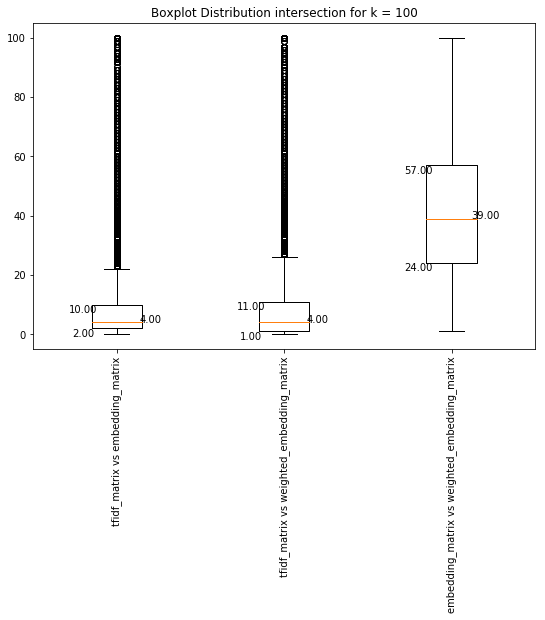

In [64]:
title = "Boxplot Distribution intersection for k = " + str(k)
filename = "imgs/n6/boxplot_comparisons_k"+ str(k)+ ".png"
       
box_plot(intersection_array, str_labels, title, filename)

Di seguito si mostrano anche le distribuzioni dei valori di similarità 

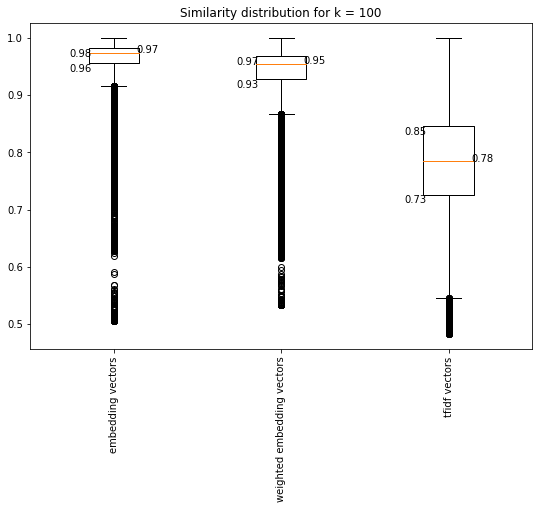

In [65]:
data_to_plot = [D_embeddings.ravel() [:100000], D_embeddings_weighted.ravel()[:100000],D_tfidf.ravel()[:100000]]
axis_labels = ['embedding vectors', 'weighted embedding vectors','tfidf vectors']
title = "Similarity distribution for k = "+ str(k)
filename = "imgs/n6/similarities_comparisons_k"+ str(k)+ ".png"
box_plot(data_to_plot, axis_labels, title, filename)

### Visualizzazione dettaglio documenti strutture (i.e. Pa e Aggiudicatari) simili

Perchè questa parte funzioni occor

In [69]:
import pandas as pd
import numpy  as np
import csv
import datetime
from time import time
import timeit

In [85]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [71]:
#scegli struttura da analizzare (scelta basata su indice di riga della matrice)
iloc_document_to_compare = 1000 #i.e. si sta analizzando la struttura 1000

#scegli la matrici da confrontare
I_matrix1 = I_embeddings
D_matrix1 = D_embeddings

I_matrix2 = I_tfidf
D_matrix2 = D_tfidf


In [116]:
file_name = "data/oggetti_aggregati.pickle"

t0 = time()
df_aggregati = pd.read_pickle(file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

df_aggregati.info()

Dataset loaded in 0.153 sec
<class 'pandas.core.frame.DataFrame'>
Int64Index: 254124 entries, 0 to 245283
Data columns (total 3 columns):
codiceFiscaleStruttura    254124 non-null object
oggetto                   254124 non-null object
tipoStruttura             254124 non-null object
dtypes: object(3)
memory usage: 7.8+ MB


In [117]:
i =  set(I_matrix1[iloc_document_to_compare]).intersection(set(I_matrix2[iloc_document_to_compare]))
print("Documenti in comune: ", i)

Documenti in comune:  {3808, 545, 5185, 2084, 1350, 1000, 2763, 300, 1393, 5335, 536, 4185, 1722, 1726}


In [118]:
pd.options.display.max_colwidth = 500
df_aggregati.iloc[[iloc_document_to_compare]]

,codiceFiscaleStruttura,oggetto,tipoStruttura
1000,298160797,fornitura di pellet per lalimentazione della caldaia dellEdificio Comunale fornitura materiali per diversi interventi manutentivi Lavori di pavimentazione di Corso Vittorio Emanuele III per lefficientamento del sistema di raccolta delle acque piovane Manutenzione mezzi comunali fornitura sacchetti per raccolta differenziata Scarifica e posa in opera tappetino per 400 ml larghezza 060m in corso Vittorio Emanuele III e Via Madonella fornitura Buoni carburanti ENI SpA Assistenza tecnica so...,PA


In [120]:
df_most_similar = df_aggregati.iloc[list(i)].set_index("codiceFiscaleStruttura")
df_most_similar.head()

,oggetto,tipoStruttura
codiceFiscaleStruttura,,
80011430487,manutenzione dispositivi anticaduta dallalto nella scuola F Paolieri a Impruneta anno 2016 derattizzazione acquisto carburante Servizi bibliotecari Comune di Impruneta 11201731122019 lavori di ristrutturazione e messa a norma dellasilo nido comunale di Tavarnuzze spese postali anno 2017 MANUTENZIONE FONTANELLI ALTA QUALITA E FORNITURA CO2 anno 2017 2018 SERVIZI AMBIENTALI I TRIMESTRE 2017 SERVIZI AMBIENTALI II TRIMESTRE 2017 SERVIZI AMBIENTALI III TRIMESTRE 2017 SERVIZI AMBIENTALI IV TRIMES...,PA
192730299,AGGIORNAMENTO TARIFFARIO MACCHINA AFFRANCATRICE Fornitura e installazione batteria mezzo fiat stylo SOSTITUZIONE SERRATURA E POSA PANNELLO PE CHIUSURA PORTA FORNITURA STABILIZZATO PER MANUTENZIONE STRADE ricarica fondo macchina affrancatrice ufficio protocollo FORNITURA STABILIZZATO PER MANUTENZIONE STRADE FORNITURA CORNICE PER ATTO DI BENEMERENZA FORNITURA ATTESTATO DI BENEMERENZA FORNITURA CARTA A3 ED A4 PER UFFICI CANONE 2017 SERVIZIO DI CONSERVAZIONE DIGITALE AI SENSI DELLART 44 DLGS 822...,PA
81003750452,servizi complementari di supporto alla gestione delle mense scolastiche dal 100117 fino alla consegna al nuovo gestore SOSTITUZIONE BATTERIA AUTOBUS EG884RW intervento chirurgico su gatto randagio intervento chirurgico e ricovero su cane randagio fornitura prodotti di pulizia stoviglie monouso e avvolgenti per alimenti ad uso mense scolastiche FORNITURA N 2000 BLOCCHETTI BUONI MENSA INTERVENTO REVISIONE INIETTORI AUTOBU FIAT DUCATO EL 432YP INTEVENTO MANUTENZIONE STRAORDINARIA LAVASTOVIGLIE...,PA
1032140582,Rinnovo abbonamento servizi telematici modalit Internet anno 2017 Rinnovo abbonamento canone servizi di base modalit Internete anno 2017 Lavaggio automezzi servizio raccolta differenziata COPIE STAMPE IN ECCEDENZA Noleggio di una fotocopiatrice multifunzionale presso la farmacia comunale Interventi di manutenzione su automezzi servizio scuolabus Riparazione automezzo servizio raccolta differenziata targato EA 773 MR Manutenzione ordinaria automezzi servizio raccolta differenziata PROTEZIONE ...,PA
398710467,fornitura annuale energia elettrica Sistemazione movimento franoso nel centro del paese di Casciana LAVORI DI REALIZZAZIONE LOCULI FRAZ FILICAIA Acquisto materiale stabilizzato sistemazione trattore comunale ACQUISTO N 2 TONER PER STAMPANTE UFFICIO ANAGRAFE STATO CIVILE E TRIBUTI PULIZIA EDIFICI COMUNALI ANNO 20182019 PRENOTAZIONE IMPEGNO RINNOVO ASSISTENZA SISTEMISTICA RINNOVO POLIZZA ASSICURATIVA AUTOMEZZi TARGATi LU457066 E BG593D ABBONAMENTO RIVISTE UFFICIO RAGIONERIA ACQUISTO REGISTRI S...,PA


In [101]:
top_feats_in_doc(matrix,  tf.get_feature_names(), iloc_document_to_compare, 5)

,feature,tfidf
0,manifestazioni,0.407447
1,culturali,0.336349
2,fornitura,0.203590
3,comunale,0.179016
4,comunali,0.153289


In [140]:
from utils import enrich_data_with_indicepa as enrich 
df_enriched = enrich.enrich_data(df_most_similar.index.astype(str))
print(df_enriched.shape)
df_enriched.set_index("cf", inplace = True)

Totale cf non presenti in IndicePA:  9
(5, 8)


In [143]:
df_enriched

,cod_amm,regione,provincia,comune,indirizzo,tipologia_istat,tipologia_amm
cf,,,,,,,
80011430487,c_e291,Toscana,FI,Impruneta,"Piazza Buondelmonti, 41",Comuni e loro Consorzi e Associazioni,Pubbliche Amministrazioni
81003750452,c_a496,Toscana,MS,Aulla,"Piazza Gramsci, 24",Comuni e loro Consorzi e Associazioni,Pubbliche Amministrazioni
80001140906,c_i863,Sardegna,SS,Sorso,Piazza Garibaldi 1,Comuni e loro Consorzi e Associazioni,Pubbliche Amministrazioni
82000370369,c_b566,Emilia Romagna,MO,Camposanto,"Via Francesco Baracca, 11",Comuni e loro Consorzi e Associazioni,Pubbliche Amministrazioni
80018470171,c_h525,Lombardia,BS,Roncadelle,"Via Roma, 50",Comuni e loro Consorzi e Associazioni,Pubbliche Amministrazioni


In [146]:
df.loc[df['cfStrutturaProponente'] == 192730299]

,cfStrutturaProponente,cig,denominazioneStrutturaProponente,oggetto,sceltaContraente,importoAggiudicazione,importoSommeLiquidate,dataInizio,dataUltimazione,jsonPartecipanti,...,totaleRaggruppamentoAggiudicatari,cfPrimoaggiudicatario,denominazionePrimoaggiudicatario,cod_amm,regione,provincia,comune,indirizzo,tipologia_istat,tipologia_amm
80152,192730299,Z901CDB029,Comune di Castelmassa,AGGIORNAMENTO TARIFFARIO MACCHINA AFFRANCATRICE,23AFFIDAMENTO IN ECONOMIA AFFIDAMENTO DIRETTO,0.00,0.0,2017-01-10,2017-01-10,"{""raggruppamento"":[],""partecipante"":[{""codiceFiscale"":""09346150155"",""identificativoFiscaleEstero"":null,""ragioneSociale"":""PITNEY BOWES ITALIA S.R.L. - DIVIS""}]}",...,0,09346150155,PITNEY BOWES ITALIA SRL DIVIS,c_c207,Veneto,RO,Castelmassa,"Piazza Vittorio Veneto, 1",Comuni e loro Consorzi e Associazioni,Pubbliche Amministrazioni
80153,192730299,ZF51CE87A2,COMUNE DI CASTELMASSA,Fornitura e installazione batteria mezzo fiat stylo,23AFFIDAMENTO IN ECONOMIA AFFIDAMENTO DIRETTO,105.00,0.0,2017-01-13,NaN,"{""raggruppamento"":[],""partecipante"":[{""codiceFiscale"":""00047260294"",""identificativoFiscaleEstero"":null,""ragioneSociale"":""F.LLI FRANCESCHETTI DI FRANCESCHET""}]}",...,0,00047260294,FLLI FRANCESCHETTI DI FRANCESCHET,c_c207,Veneto,RO,Castelmassa,"Piazza Vittorio Veneto, 1",Comuni e loro Consorzi e Associazioni,Pubbliche Amministrazioni
80154,192730299,Z151CF4B29,COMUNE DI CASTELMASSA,SOSTITUZIONE SERRATURA E POSA PANNELLO PE CHIUSURA PORTA,23AFFIDAMENTO IN ECONOMIA AFFIDAMENTO DIRETTO,115.00,0.0,2017-01-17,2017-01-17,"{""raggruppamento"":[],""partecipante"":[{""codiceFiscale"":""01131810291"",""identificativoFiscaleEstero"":null,""ragioneSociale"":""MINERVINI COSIMO""}]}",...,0,01131810291,MINERVINI COSIMO,c_c207,Veneto,RO,Castelmassa,"Piazza Vittorio Veneto, 1",Comuni e loro Consorzi e Associazioni,Pubbliche Amministrazioni
80155,192730299,Z591D0A5F2,COMUNE DI CASTELMASSA,FORNITURA STABILIZZATO PER MANUTENZIONE STRADE,23AFFIDAMENTO IN ECONOMIA AFFIDAMENTO DIRETTO,196.28,0.0,2017-01-23,2017-01-24,"{""raggruppamento"":[],""partecipante"":[{""codiceFiscale"":""01419250293"",""identificativoFiscaleEstero"":null,""ragioneSociale"":""MARKET EDILIZIA""}]}",...,0,01419250293,MARKET EDILIZIA,c_c207,Veneto,RO,Castelmassa,"Piazza Vittorio Veneto, 1",Comuni e loro Consorzi e Associazioni,Pubbliche Amministrazioni
80156,192730299,ZDB1D36996,Comune di Castelmassa,ricarica fondo macchina affrancatrice ufficio protocollo,23AFFIDAMENTO IN ECONOMIA AFFIDAMENTO DIRETTO,580.00,0.0,2017-02-03,2017-02-03,"{""raggruppamento"":[],""partecipante"":[{""codiceFiscale"":""09346150155"",""identificativoFiscaleEstero"":null,""ragioneSociale"":""PITNEY BOWES ITALIA S.R.L. - DIVIS""}]}",...,0,09346150155,PITNEY BOWES ITALIA SRL DIVIS,c_c207,Veneto,RO,Castelmassa,"Piazza Vittorio Veneto, 1",Comuni e loro Consorzi e Associazioni,Pubbliche Amministrazioni
80157,192730299,Z9A1D3CDB9,COMUNE DI CASTELMASSA,FORNITURA STABILIZZATO PER MANUTENZIONE STRADE,23AFFIDAMENTO IN ECONOMIA AFFIDAMENTO DIRETTO,196.28,0.0,2017-02-06,2017-02-06,"{""raggruppamento"":[],""partecipante"":[{""codiceFiscale"":""01419250293"",""identificativoFiscaleEstero"":null,""ragioneSociale"":""MARKET EDILIZIA""}]}",...,0,01419250293,MARKET EDILIZIA,c_c207,Veneto,RO,Castelmassa,"Piazza Vittorio Veneto, 1",Comuni e loro Consorzi e Associazioni,Pubbliche Amministrazioni
80158,192730299,ZC81D4F289,COMUNE DI CASTELMASSA,FORNITURA CORNICE PER ATTO DI BENEMERENZA,23AFFIDAMENTO IN ECONOMIA AFFIDAMENTO DIRETTO,25.00,0.0,2017-02-09,2017-02-09,"{""raggruppamento"":[],""partecipante"":[]}",...,0,01094800297,VALERI FRANCESCOCORNICERIA MOBILI,c_c207,Veneto,RO,Castelmassa,"Piazza Vittorio Veneto, 1",Comuni e loro Consorzi e Associazioni,Pubbliche Amministrazioni
80159,192730299,Z951D4F189,COMUNE DI CASTELMASSA,FORNITURA ATTESTATO DI BENEMERENZA,23AFFIDAMENTO IN ECONOMIA AFFIDAMENTO DIRETTO,5.00,0.0,2017-02-09,2017-02-09,"{""raggruppamento"":[],""partecipante"":[{""codiceFiscale"":""00257

### Confronto distribuzioni similarità

### Dettaglio documenti strutture (i.e. PA, Aggiudicatari) simili

In [ ]:
file_name = "data/oggetti_aggregati.pickle"

t0 = time()
df = pd.read_pickle(file_name)
total = time() - t0

print("Dataset loaded in %0.3f sec" % total)

df.info()

In [ ]:
from utils import enrich_data_with_indicepa as enrich 
df_enriched = enrich.enrich_data(df.codiceFiscaleStruttura.astype(str))
print(df_enriched.shape)
df_enriched.set_index("cf", inplace = True)

In [ ]:
i =  set(I_embeddings[row]).intersection(set(I_tfidf[row]))
print("Documenti in comune: ", i)

In [ ]:
df.iloc[[iloc_document_to_compare]]

In [ ]:
pd.options.display.max_colwidth = 500
df_I_embedding = df.iloc[I_embeddings[iloc_document_to_compare]]
df_I_embedding["codiceFiscaleStruttura"] = df_I_embedding["codiceFiscaleStruttura"].astype(str)
df_I_embedding.set_index("codiceFiscaleStruttura", inplace= True)

#df_I_embedding.head()
#aggiunge info da indice Pa se il codice fiscale è inluso
df_I_embedding.join(df_enriched)

In [ ]:
pd.options.display.max_colwidth = 500

df_I_tfidf = df.iloc[I_tfidf[iloc_document_to_compare]]
df_I_tfidf["codiceFiscaleStruttura"] = df_I_tfidf["codiceFiscaleStruttura"].astype(str)
df_I_tfidf.set_index("codiceFiscaleStruttura", inplace= True)

#df_I_embedding.head()
#aggiunge info da indice Pa se il codice fiscale è inluso
df_I_tfidf.join(df_enriched)


In [ ]:
D_embeddings[:10]

In [ ]:
[D_embeddings[iloc_document_to_compare]]

In [ ]:
[D_tfidf[iloc_document_to_compare]]

In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [ ]:
#visualizza i termini con i valori piu alti di tf-idf
#top_feats_in_doc(matrix,  tf.get_feature_names(), 1000, 5)

In [ ]:
type(D_embeddings[0])

In [ ]:
df[df["tipoStruttura"] == "PA"].shape

In [ ]:
cosine_iterator = cosine_similarity(matrix)

In [ ]:
from scipy.sparse import lil_matrix

t0 = time()

cosine_matrix = lil_matrix((matrix.shape[0], matrix.shape[0]))
#cosine_matrix = lil_matrix((1000, 1000))
counter = 0
for x in cosine_iterator:
    if(x[2]>= 0.6):
        cosine_matrix[x[0],x[1]] = x[2]
        counter += 1
        
total = time() - t0
print("Cosine Matrix done in %0.3f sec" % total)
print("There are %d pairs with a cosine similarity greater than 0.6" % counter)

np.save("data/n6/cosine_matrix", cosine_matrix)

In [ ]:
counter

In [ ]:
#from multiprocessing import Pool
#from scipy import spatial
#from time import time

#n = matrix.shape[0]
#lst = ((i, j) for i in range(0, n) for j in range(i+1,n))

#def cosine(p):
#    i = p[0]
#    j = p[1]
    
#    if spatial.distance.cosine(matrix[i], matrix[j]) > 0.6:
#        return i,j, 1 - spatial.distance.cosine(matrix[i], matrix[j])

##if __name__ == '__main__':

#t0 = time()
#p = Pool(6)
#a = p.imap(cosine, lst)
#total = time() - t0
#print(total)
#a = filter(None, a)

In [ ]:
counter = 0
for el in a:
    counter += 1

In [ ]:
print(counter)

## References

[1] https://buhrmann.github.io/tfidf-analysis.html